In this notebook, we plot the differential sensitivities and compare them to model spectra taken from Fig. 1 in https://arxiv.org/abs/2008.12318

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import argparse
import histlite as hl
import csky as cy

cy.plotting.mrichman_mpl()

timer = cy.timing.Timer()
time = timer.time

gamma = 2.0
dt = 0.01

FRB_mjd_time = [57760.83732799769, 57547.161818148146, 57488.35670925926, 57464.37542280093, 57389.35323349537, 57386.67762181713, 57362.262416412035, 57241.74578506944, 57183.22707634259, 57130.18688260417, 57068.86228835648, 56791.718183564815, 56600.752907407405, 56502.376286921295, 56471.165279837965, 56469.62221957176, 56202.5481300463, 55953.341223668984, 55745.79144221065, 55738.89811894676, 55704.629394675925, 55612.080417777775]

FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 2.811899957888065, 1.9050268785518107, 4.788485335771643, 5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623, 6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

#Building/loading MESC data from analysis directory
ana_dir = cy.utils.ensure_dir('/data/user/mkovacevich/FRB_analysis/cascades_ana')
repo = cy.selections.Repository()
ana = cy.analysis.Analysis(repo, cy.selections.MESEDataSpecs.mesc_7yr, dir=ana_dir)

cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 10

src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient"} #,'flux': cy.hyp.PowerLawFlux(gamma)}

In [81]:
with time('background estimation'):
    allE_tr = cy.get_trial_runner(conf, ana=ana, src=src)
    bg = cy.dists.TSD(allE_tr.get_many_fits(10000, mp_cpus=10))

Performing 10000 background trials using 10 cores:
      10000/10000 trials complete.   

0:00:09.867530 elapsed.


In [82]:
# you could also use np.logspace()
Ebins = 10**np.r_[3:7.1:.25]
trs = [
    cy.get_trial_runner(conf, 
        ana=ana, src=src,
        flux=cy.hyp.PowerLawFlux(gamma, energy_range=(Emin, Emax)))
    for (Emin, Emax) in zip(Ebins[:-1], Ebins[1:])
]

exception raised trying to construct <class 'csky.inj.TransientInjector'>
exception raised trying to construct <class 'csky.trial.TrialRunner'>


TypeError: bad operand type for unary -: 'list'

In [7]:
senss = []

with time('differential sensitivity'):
    for (Emin, Emax, tr) in zip(Ebins[:-1], Ebins[1:], trs):
        print(f'log10(E) bin: {np.log10(Emin), np.log10(Emax)}')
        sens = tr.find_n_sig(
            bg.median(), .9, batch_size=500, max_batch_size=500,
            seed=1, mp_cpus=10)
        # N.B. must set E0 to a value within the energy_range
        # of the flux for this trial runner
        sens['E2dNdE'] = tr.to_E2dNdE(sens, E0=Emin)
        senss.append(sens)

log10(E) bin: (3.0, 3.25)
Start time: 2021-01-11 12:05:26.122016
Using 10 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 3.000 ... frac = 0.94000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    1.20    2.40    3.60    4.80    6.00  |  n_sig(relative error)
500      |          0.0%   70.0%   91.6%   97.8%   99.6%   99.8%  |      2.231 (+/-  4.7%) [spline]
End time: 2021-01-11 12:06:56.780532
Elapsed time: 0:01:30.658516
log10(E) bin: (3.25, 3.5)
Start time: 2021-01-11 12:06:56.782573
Using 10 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 3.000 ... frac = 0.94000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    1.20    2.40    3.60    4.80    6.00  |  n_sig(relative error)
500      |          0.0%   70.0%   91.6%   97.8%   99.6%   99.8%  |      2.231 (+/-  4.7%) [spline]
End time: 2021-01-11 12:08:49.988808
Elapsed time: 0:01:53.206235
log10(E) bin: (3.5, 3.75)
Start time: 2021-01-11

In [8]:
fluxs = [s['E2dNdE']/1e3 for s in senss] # convert GeV->TeV
diffsens = hl.Hist(Ebins, fluxs)
diffsens

Hist(16 bins in [1000.0,10000000.0], with sum 0.19881000595459553, 0 empty bins, and 0 non-finite values)

In [3]:
'''
Overlaying the sensitivities from Metzger, Margalit and Fang
'''

#Loading extracted data into arrays
energy_non_thermal_one_s = np.load('./Model_Spectra/energy_non_thermal_one_s.npy', allow_pickle = True)
energy_non_thermal_ten_s = np.load('./Model_Spectra/energy_non_thermal_ten_s.npy', allow_pickle = True)
energy_non_thermal_onehundred_ms = np.load('./Model_Spectra/energy_non_thermal_onehundred_ms.npy', allow_pickle = True)
energy_non_thermal_ten_ms = np.load('./Model_Spectra/energy_non_thermal_ten_ms.npy', allow_pickle = True)
energy_total_non_thermal = np.load('./Model_Spectra/energy_total_non_thermal.npy', allow_pickle = True)
energy_thermal = np.load('./Model_Spectra/energy_thermal.npy', allow_pickle = True)

sens_non_thermal_one_s = np.load('./Model_Spectra/sens_non_thermal_one_s.npy', allow_pickle = True)
sens_non_thermal_ten_s = np.load('./Model_Spectra/sens_non_thermal_ten_s.npy', allow_pickle = True)
sens_non_thermal_onehundred_ms = np.load('./Model_Spectra/sens_non_thermal_onehundred_ms.npy', allow_pickle = True)
sens_non_thermal_ten_ms = np.load('./Model_Spectra/sens_non_thermal_ten_ms.npy', allow_pickle = True)
sens_total_non_thermal = np.load('./Model_Spectra/sens_total_non_thermal.npy', allow_pickle = True)
sens_thermal = np.load('./Model_Spectra/sens_thermal.npy', allow_pickle = True)


### Loading MESC 7yr Differential Sensitivities
#senss1 = senss = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(gamma, dt), allow_pickle=True)

In [25]:
Ebins = 10**np.r_[3:6.51:.25]
len(Ebins)

15

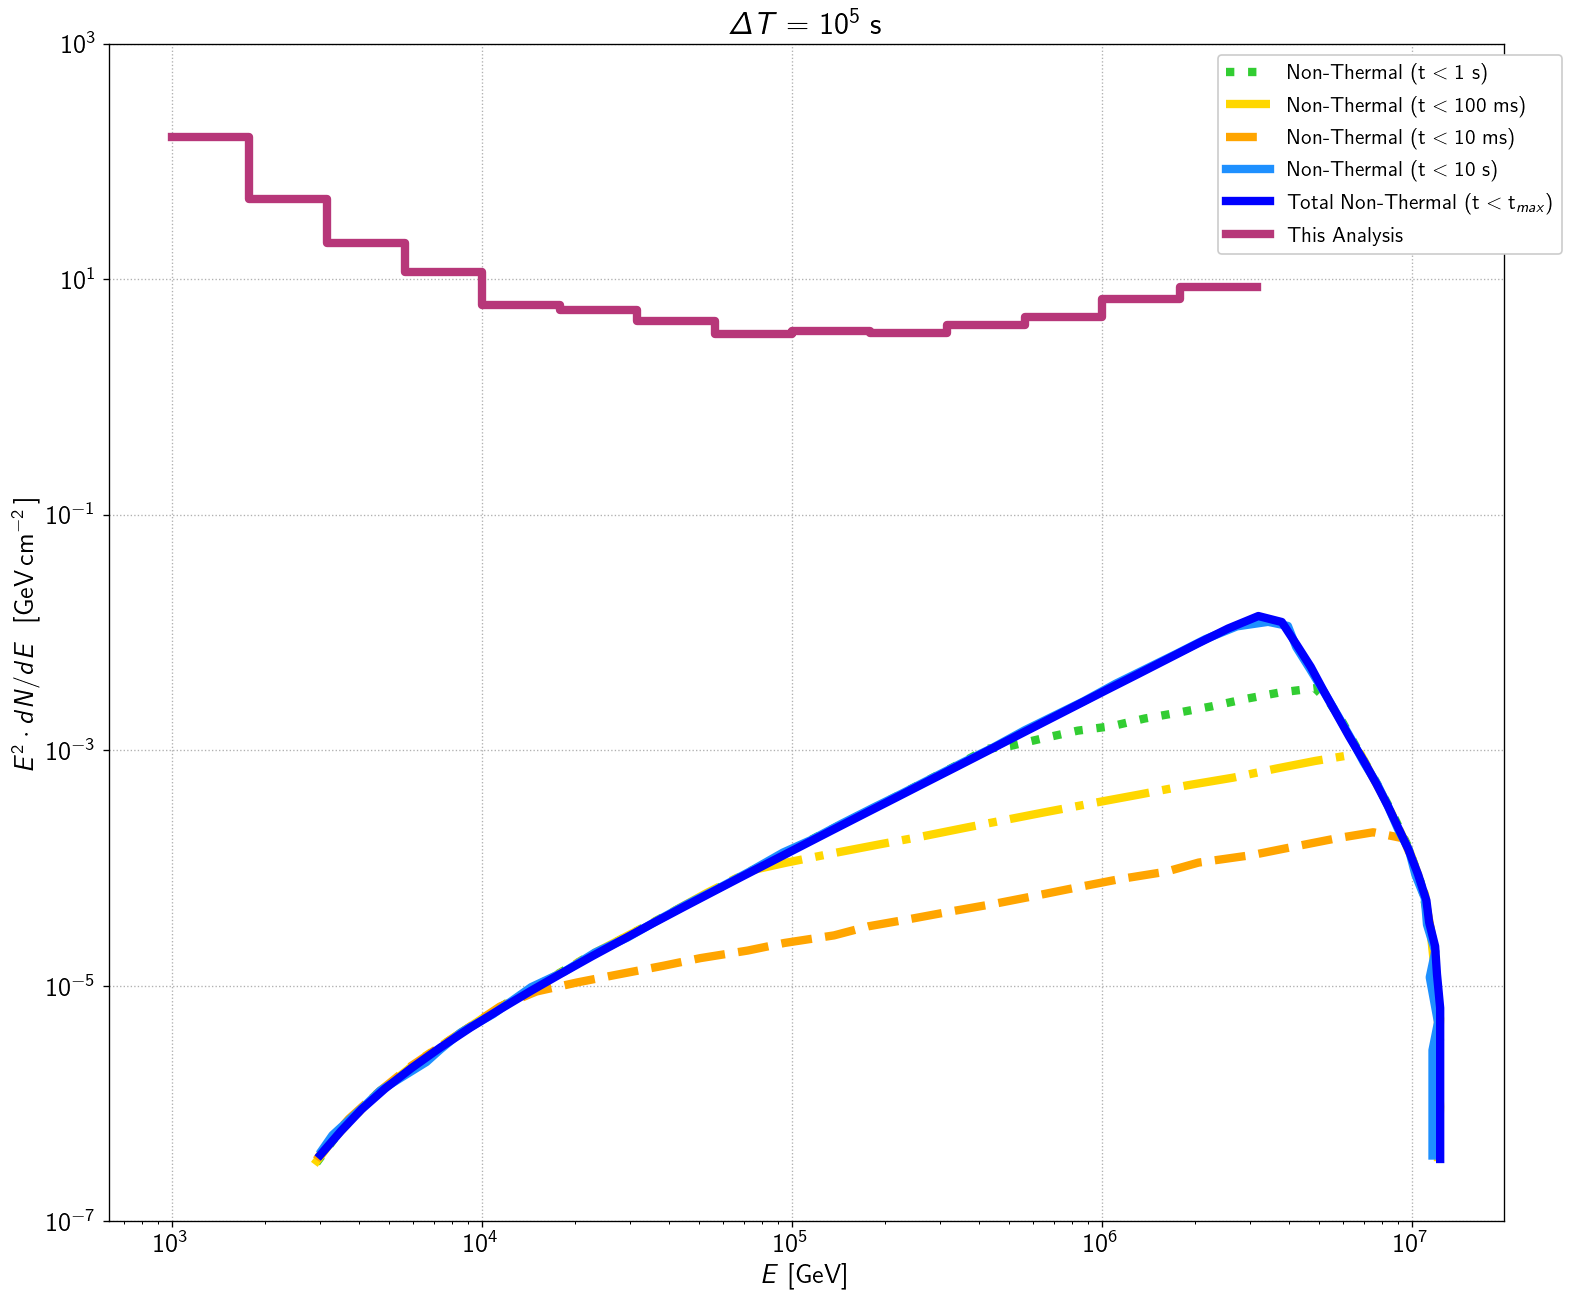

In [13]:
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(1, 1, figsize=(15,13))

Ebins = 10**np.r_[3:6.51:.25]
#Modified_Ebins = 10**np.r_[3:5.1:.25]
gamma = [2.0]
#dt = np.logspace(-2, 5, 8)
dt = [100000.0]
i = 100000.0
pow = np.log10(dt)
#title = 'Differential Sensitivities and Model Spectra' #: $\gamma={gamma:.1f}$ ' #, dt=10^{{{pow:.0f}}}$ s'

color_divisor = 4.0
sens_2 = {}
flux_2 = {}
diffsens_2 = {}

    
pow = np.log10(i)
g = 2.0
    
sens_2[i] = np.load('/data/user/mkovacevich/FRB_analysis/Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
flux_2[i] = [s['E2dNdE'] for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
diffsens_2[i] = hl.Hist(Ebins, flux_2[i][:14])
hl.plot1d(ax, diffsens_2[i], label = 'This Analysis', color = plt.get_cmap('magma')(g/color_divisor), linewidth = '5.')
    
ax.plot(energy_non_thermal_one_s, sens_non_thermal_one_s, color = 'limegreen', ls = ':', label = r'Non-Thermal $(\text{t} < \text{1 s} )$', linewidth = '5.')
ax.plot(energy_non_thermal_onehundred_ms, sens_non_thermal_onehundred_ms, color = 'gold', ls = '-.', label = r'Non-Thermal $(\text{t} < \text{100 ms} )$', linewidth = '5.')
#ax.plot(energy_thermal, sens_thermal, color = 'red', label = r'Thermal $(\text{t} < \text{t}_{nth} )$', linewidth = '5.')
ax.plot(energy_non_thermal_ten_ms, sens_non_thermal_ten_ms, color = 'orange', ls = '--', label = r'Non-Thermal $(\text{t} < \text{10 ms} )$' , linewidth = '5.')
ax.plot(energy_non_thermal_ten_s, sens_non_thermal_ten_s, color = 'dodgerblue', label = r'Non-Thermal $(\text{t} < \text{10 s} )$', linewidth = '5.')
ax.plot(energy_total_non_thermal, sens_total_non_thermal, color = 'blue', label = r'Total Non-Thermal $(\text{t} < \text{t}_{max} )$', linewidth = '5.')
        #ax.axvline(np.median(t.ts), color=color,label=r'$n_\text{{inj}}={}$ median'.format(n_sig), ls='--',alpha = .6)
ax.set(ylim = (1e-7, 1e3),
    xlabel=r'$E$ [GeV]',
    ylabel=r'$E^2\cdot dN/dE~~[\text{GeV}\,\text{cm}^{-2}\,\text{}]$',
    title=fr'$\Delta T = 10^{{{pow:.0f}}}$ s'
    )
#ax.set_ylim(top = 1e3)
ax.grid()
ax.loglog()
ax.legend(bbox_to_anchor=(1.05, 1), prop={'size': 13})
    
#fig.suptitle(title, y = .95, fontsize=25) #, fontdict = {'fontsize' : 100})
plt.subplots_adjust(wspace = .75, hspace=.35)
fig.savefig('/home/mkovacevich/public_html/Qual/FRB_DifferentialSensitivity_Overlaid.png',bbox_inches='tight')


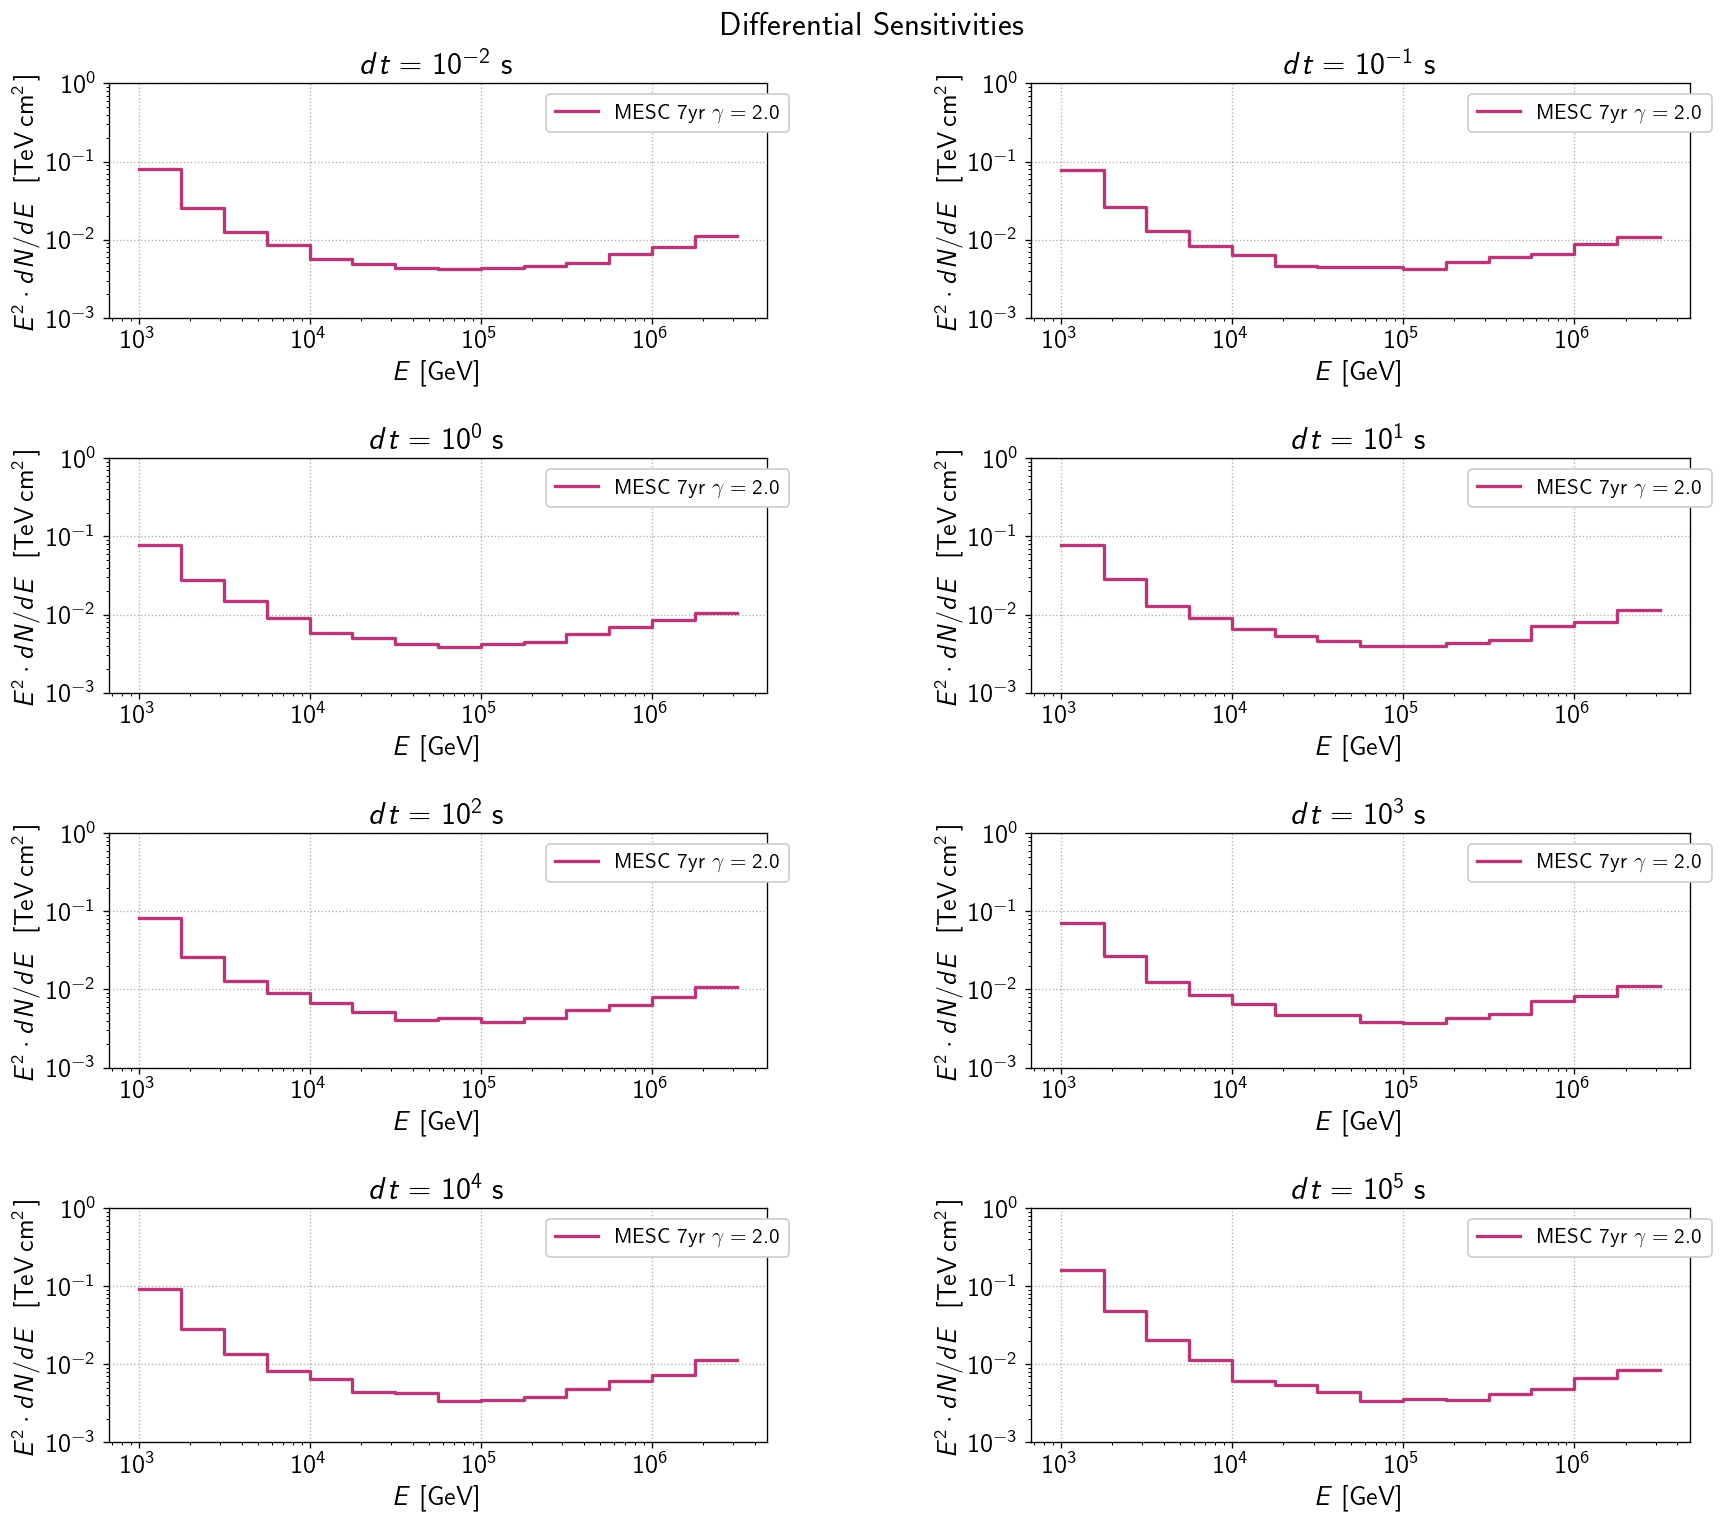

In [39]:
### Testing out using less bins at higher energies ###
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(4, 2, figsize=(17,15))

Ebins = 10**np.r_[3:6.51:.25]
gamma = [2.0]
dt = np.logspace(-2, 5, 8)

pow = np.log10(dt)
title = 'Differential Sensitivities' #: $\gamma={gamma:.1f}$ ' #, dt=10^{{{pow:.0f}}}$ s'

color_divisor = 4.0
sens_2 = {}
flux_2 = {}
diffsens_2 = {}

for i in dt:
    g = 2.0
    pow = np.log10(i)

    sens_2[i] = np.load('/data/user/mkovacevich/FRB_analysis/Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
    flux_2[i] = [s['E2dNdE']/1e3 for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
    #len(flux_2[i:15])
    diffsens_2[i] = hl.Hist(Ebins, flux_2[i][:14])
    hl.plot1d(ax, diffsens_2[i], label = fr'MESC 7yr $\gamma={g:.1f}$ ', color = plt.get_cmap('magma')(g/color_divisor))
            
            
    ax.set(ylim = (1e-3, 1e0),
    xlabel=r'$E$ [GeV]',
    ylabel=r'$E^2\cdot dN/dE~~[\text{TeV}\,\text{cm}^2\,\text{}]$',
    title=fr'$dt=10^{{{pow:.0f}}}$ s'
    )
    #ax.set_ylim(top = 1e3)
    ax.grid()
    ax.loglog()
    ax.legend(bbox_to_anchor=(1.05, 1), prop={'size': 13})
    
fig.suptitle(title, y = .92, fontsize=20) #, fontdict = {'fontsize' : 100})
plt.subplots_adjust(wspace = .4, hspace=.6)
fig.savefig('/home/mkovacevich/public_html/plots/DiffSens/Differential_Sensitivity.png',bbox_inches='tight')

0.01
100000.0
Hist(14 bins in [1000.0,3162277.6601683795], with sum 31.67680832578053, 0 empty bins, and 0 non-finite values)
Hist(14 bins in [1000.0,3162277.6601683795], with sum 35.003386470893034, 0 empty bins, and 0 non-finite values)
Hist(14 bins in [1000.0,3162277.6601683795], with sum 15.474756141179657, 0 empty bins, and 0 non-finite values)


/home/mkovacevich/py3venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


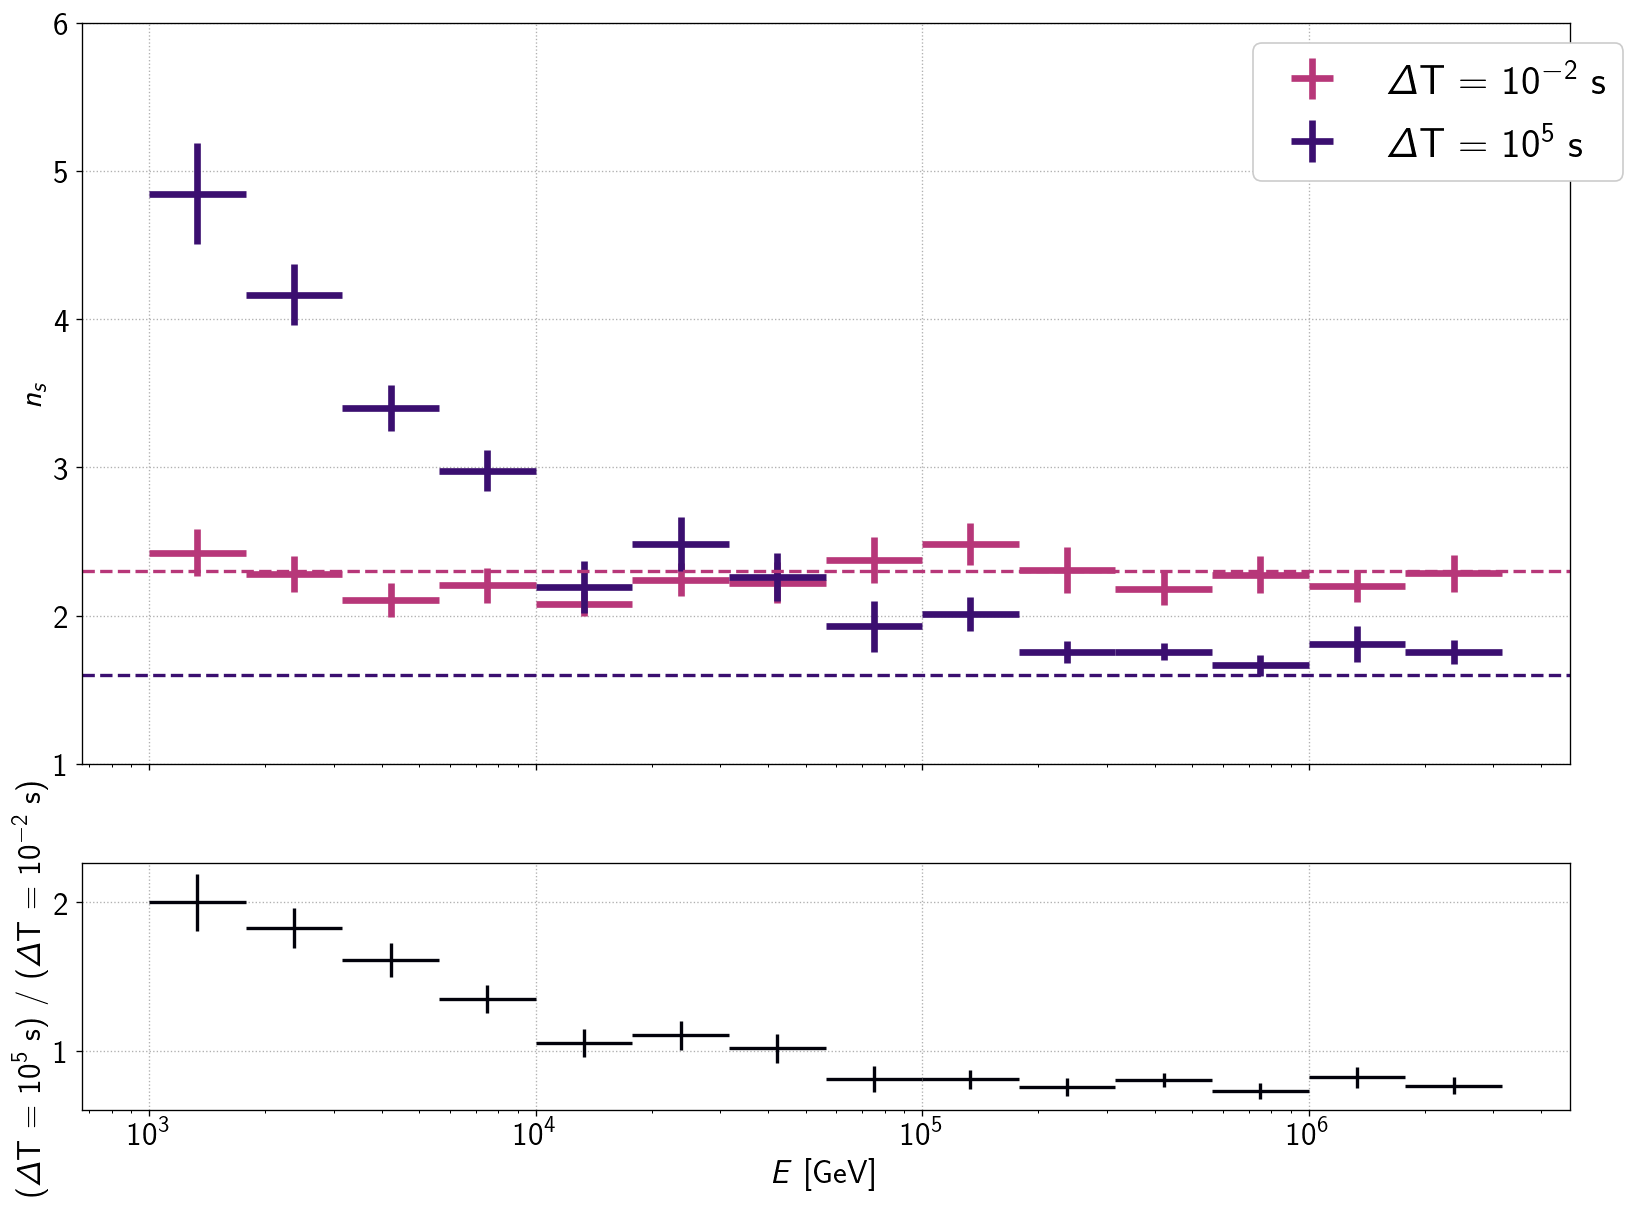

In [4]:
# Plotting the difference between differential sensitivities for smallest and largest dt
plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2) = plt.subplots(2, figsize=(16,12), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)

Ebins = 10**np.r_[3:6.51:.25]
gamma = [2.0]
dt = np.logspace(-2, 5, 2)

#Smallest and largest time windows
i = dt[0]
pow_small = np.log(i)
j = dt[1]
pow_small = np.log(i)
print(i)
print(j)
pow = np.log10(dt)

color_divisor = 4.0
sens_2 = {}
flux_2 = {}
error_2 = {}
diffsens_2 = {}
diff_sens_smallest_dt = {}
diff_sens_largest_dt = {}

sens_large_2 = {}
flux_large_2 = {}
error_large_2 = {}

g = 2.0

error_large={}
error_small={}
    
sens_2[i] = np.load('/data/user/mkovacevich/FRB_analysis/Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
#flux_2[i] = [s['E2dNdE'] for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
flux_2[i] = [s['n_sig'] for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
error_2[i] = [s['n_sig_error']*s['n_sig'] for s in sens_2[i]]
diff_sens_smallest_dt[i] = hl.Hist(Ebins, flux_2[i][:14], error_2[i][:14])
error_small = hl.LineStyle(crosses=True)
hl.plot1d(ax1, diff_sens_smallest_dt[i], crosses = True, label = fr'$\Delta$T = $10^{{{pow[0]:.0f}}}$ s', color = plt.get_cmap('magma')(g/4), linewidth = 4.)
#hl.LineStyle(errorbars = True, crosses=True)
print(diff_sens_smallest_dt[i])

sens_large_2[j] = np.load('/data/user/mkovacevich/FRB_analysis/Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, j), allow_pickle=True)
#flux_large_2[j] = [s['E2dNdE'] for s in sens_large_2[j]] #Units of Gev, divide by 1e3 for units of TeV
flux_large_2[j] = [s['n_sig'] for s in sens_large_2[j]] #Units of Gev, divide by 1e3 for units of TeV
error_large_2[j] = [s['n_sig_error']*s['n_sig'] for s in sens_large_2[j]]
diff_sens_largest_dt[j] = hl.Hist(Ebins, flux_large_2[j][:14], error_large_2[j][:14])
error_large = hl.LineStyle(errorbars = True)
hl.plot1d(ax1, diff_sens_largest_dt[j], crosses = True, label = fr'$\Delta$T = $10^{{{pow[1]:.0f}}}$ s', color = plt.get_cmap('magma')(g/10), linewidth =4.)
print(diff_sens_largest_dt[j])
print(np.divide(diff_sens_largest_dt[j],diff_sens_smallest_dt[i]))

#diff_sens_ratio[j] = hl.Hist(Ebins, np.divide(diff_sens_largest_dt[j],diff_sens_smallest_dt[i]))
diff_sens_ratio = {}
diff_sens_ratio = np.divide(diff_sens_largest_dt[j],diff_sens_smallest_dt[i])
diff_sens_ratio = diff_sens_largest_dt[j] / diff_sens_smallest_dt[i]

hl.plot1d(ax2, diff_sens_ratio, crosses = True, label = r'$n_{s}$ ratio', color = plt.get_cmap('magma')(g/100)) #, linewidth =4)


ax1.set(ylim = (1e0, 6),
    #ylabel=r'$E^2\cdot dN/dE~~[\text{GeV}\,\text{cm}^2\,\text{}]$',
    ylabel = r'$n_{s}$'
    #,title = 'Differential Sensitivities'
    )
ax1.grid()
ax1.axhline(2.3, color = plt.get_cmap('magma')(g/4), ls = '--')
ax1.axhline(1.6, color = plt.get_cmap('magma')(g/10), ls = '--')
ax1.semilogx()
ax1.legend(bbox_to_anchor=(1.05, 1), prop={'size': 25})

ax2.set(xlabel=r'$E$ [GeV]' ,ylabel = fr'($\Delta$T = $10^{{{pow[1]:.0f}}}$ s) / ($\Delta$T = $10^{{{pow[0]:.0f}}}$ s) ' )

ax2.grid()
#ax2.legend(bbox_to_anchor=(1.05, 1), prop={'size': 15})
fig.savefig('/home/mkovacevich/public_html/Qual/N_sig_vs_E.png',bbox_inches='tight')

0.01
100000.0
Hist(14 bins in [1000.0,3162277.6601683795], with sum 185.69820294113612, 0 empty bins, and 0 non-finite values)
Hist(14 bins in [1000.0,3162277.6601683795], with sum 292.6196650122568, 0 empty bins, and 0 non-finite values)
Hist(14 bins in [1000.0,3162277.6601683795], with sum 15.652658738389478, 0 empty bins, and 0 non-finite values)


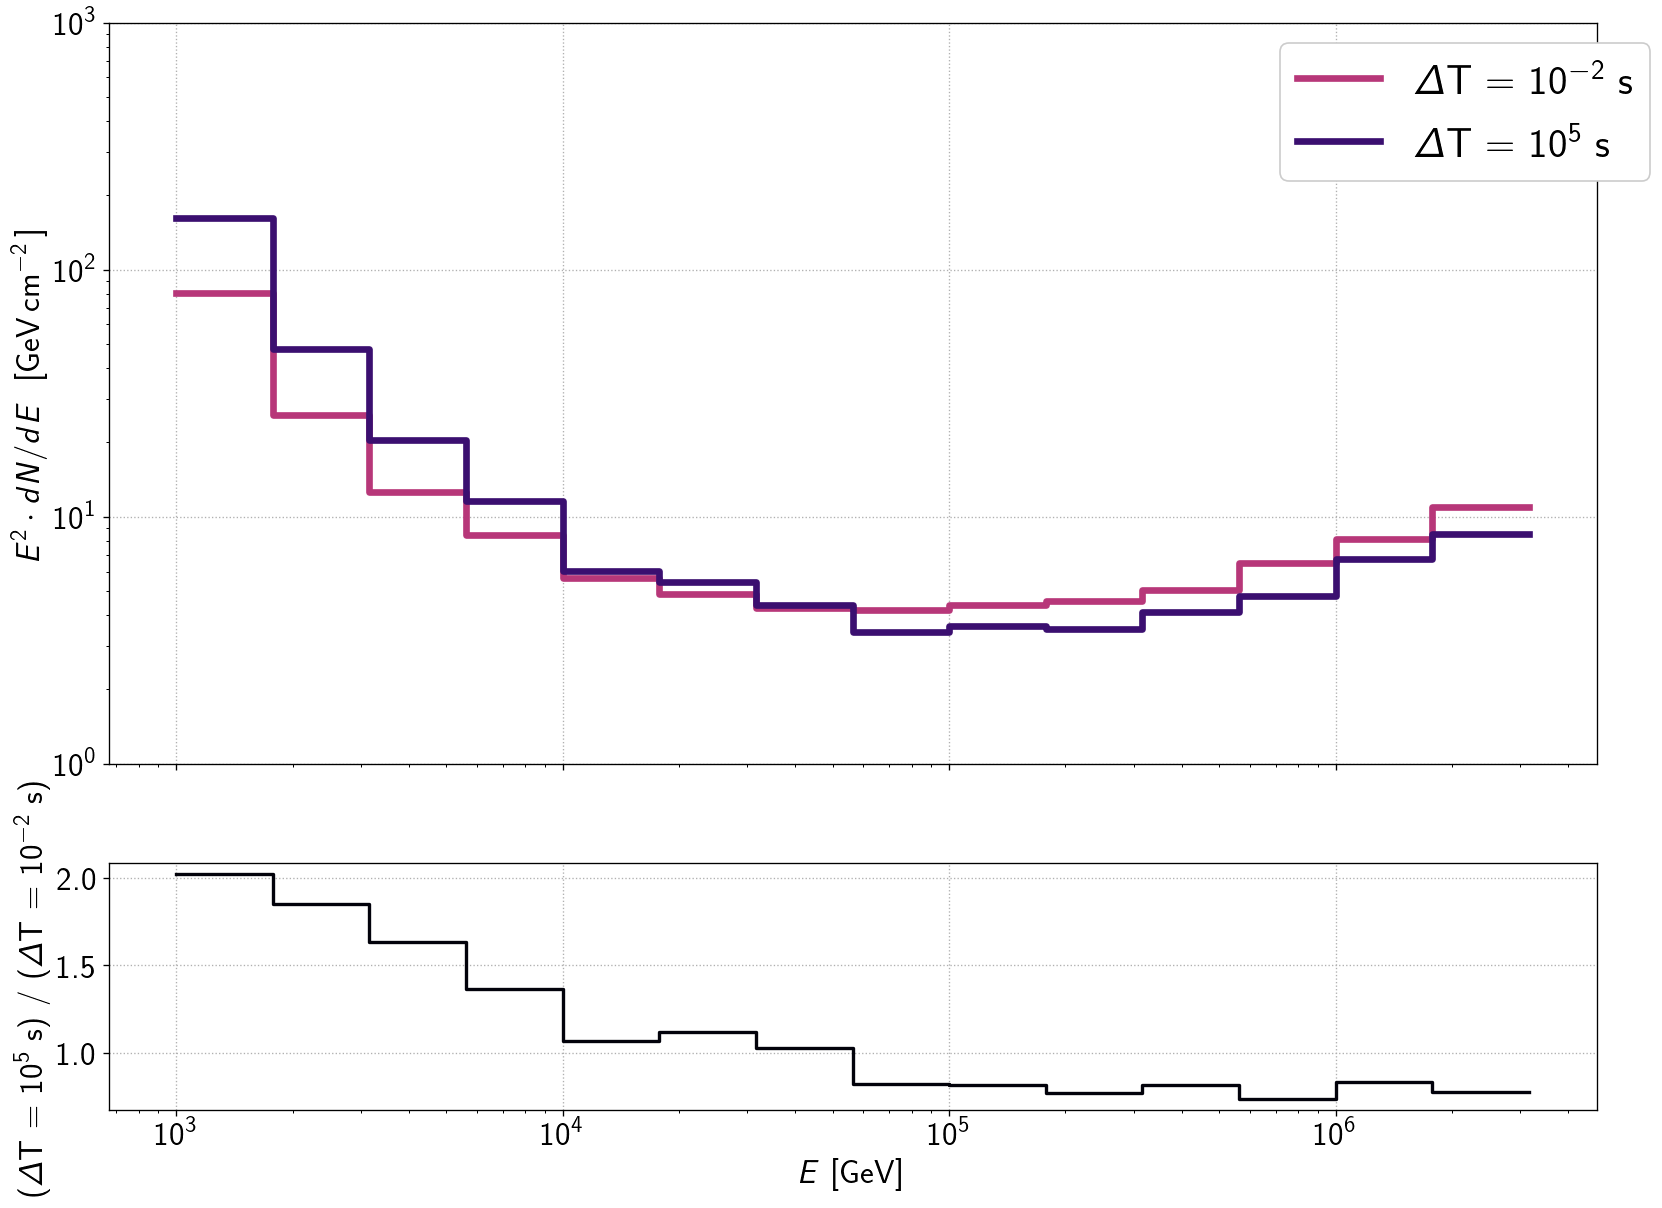

In [16]:
# Plotting the difference between n_sig for smallest and largest dt
plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2) = plt.subplots(2, figsize=(16,12), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)

Ebins = 10**np.r_[3:6.51:.25]
gamma = [2.0]
dt = np.logspace(-2, 5, 2)

#Smallest and largest time windows
i = dt[0]
pow_small = np.log(i)
j = dt[1]
pow_small = np.log(i)
print(i)
print(j)
pow = np.log10(dt)

color_divisor = 4.0
sens_2 = {}
flux_2 = {}
error_2 = {}
diffsens_2 = {}
diff_sens_smallest_dt = {}
diff_sens_largest_dt = {}

sens_large_2 = {}
flux_large_2 = {}
error_large_2 = {}

g = 2.0

error_large={}
error_small={}
    
sens_2[i] = np.load('/data/user/mkovacevich/FRB_analysis/Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
flux_2[i] = [s['E2dNdE'] for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
#flux_2[i] = [s['n_sig'] for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
error_2[i] = [s['n_sig_error']*s['n_sig'] for s in sens_2[i]]
diff_sens_smallest_dt[i] = hl.Hist(Ebins, flux_2[i][:14])
#error_small = hl.LineStyle(crosses=True)
hl.plot1d(ax1, diff_sens_smallest_dt[i], label = fr'$\Delta$T = $10^{{{pow[0]:.0f}}}$ s', color = plt.get_cmap('magma')(g/4), linewidth = 4.)
#hl.LineStyle(errorbars = True, crosses=True)
print(diff_sens_smallest_dt[i])

sens_large_2[j] = np.load('/data/user/mkovacevich/FRB_analysis/Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, j), allow_pickle=True)
flux_large_2[j] = [s['E2dNdE'] for s in sens_large_2[j]] #Units of Gev, divide by 1e3 for units of TeV
#flux_large_2[j] = [s['n_sig'] for s in sens_large_2[j] ] #Units of Gev, divide by 1e3 for units of TeV
error_large_2[j] = [s['n_sig_error']*s['n_sig'] for s in sens_large_2[j]]
diff_sens_largest_dt[j] = hl.Hist(Ebins, flux_large_2[j][:14])
#error_large = hl.LineStyle(errorbars = True)
hl.plot1d(ax1, diff_sens_largest_dt[j], label = fr'$\Delta$T = $10^{{{pow[1]:.0f}}}$ s', color = plt.get_cmap('magma')(g/10), linewidth =4.)
print(diff_sens_largest_dt[j])
print(np.divide(diff_sens_largest_dt[j],diff_sens_smallest_dt[i]))

#diff_sens_ratio[j] = hl.Hist(Ebins, np.divide(diff_sens_largest_dt[j],diff_sens_smallest_dt[i]))
diff_sens_ratio = {}
diff_sens_ratio = np.divide(diff_sens_largest_dt[j],diff_sens_smallest_dt[i])
diff_sens_ratio = diff_sens_largest_dt[j] / diff_sens_smallest_dt[i]

hl.plot1d(ax2, diff_sens_ratio, label = r'Differential sensitivity ratio', color = plt.get_cmap('magma')(g/100)) #, linewidth =4)


ax1.set(ylim = (1e0, 1e3),
    ylabel=r'$E^2\cdot dN/dE~~[\text{GeV}\,\text{cm}^{-2}\,\text{}]$',
    )
ax1.grid()
ax1.loglog()
ax1.legend(bbox_to_anchor=(1.05, 1), prop={'size': 25})

ax2.set(xlabel=r'$E$ [GeV]' ,ylabel = fr'($\Delta$T = $10^{{{pow[1]:.0f}}}$ s) / ($\Delta$T = $10^{{{pow[0]:.0f}}}$ s) ')

ax2.grid()
#ax2.legend(bbox_to_anchor=(1.05, 1), prop={'size': 15})
#plt.subplots_adjust(hspace = 1.0)
fig.savefig('/home/mkovacevich/public_html/Qual/DifferentialSensitivityComparison.png',bbox_inches='tight')

NameError: name 'sens_3' is not defined

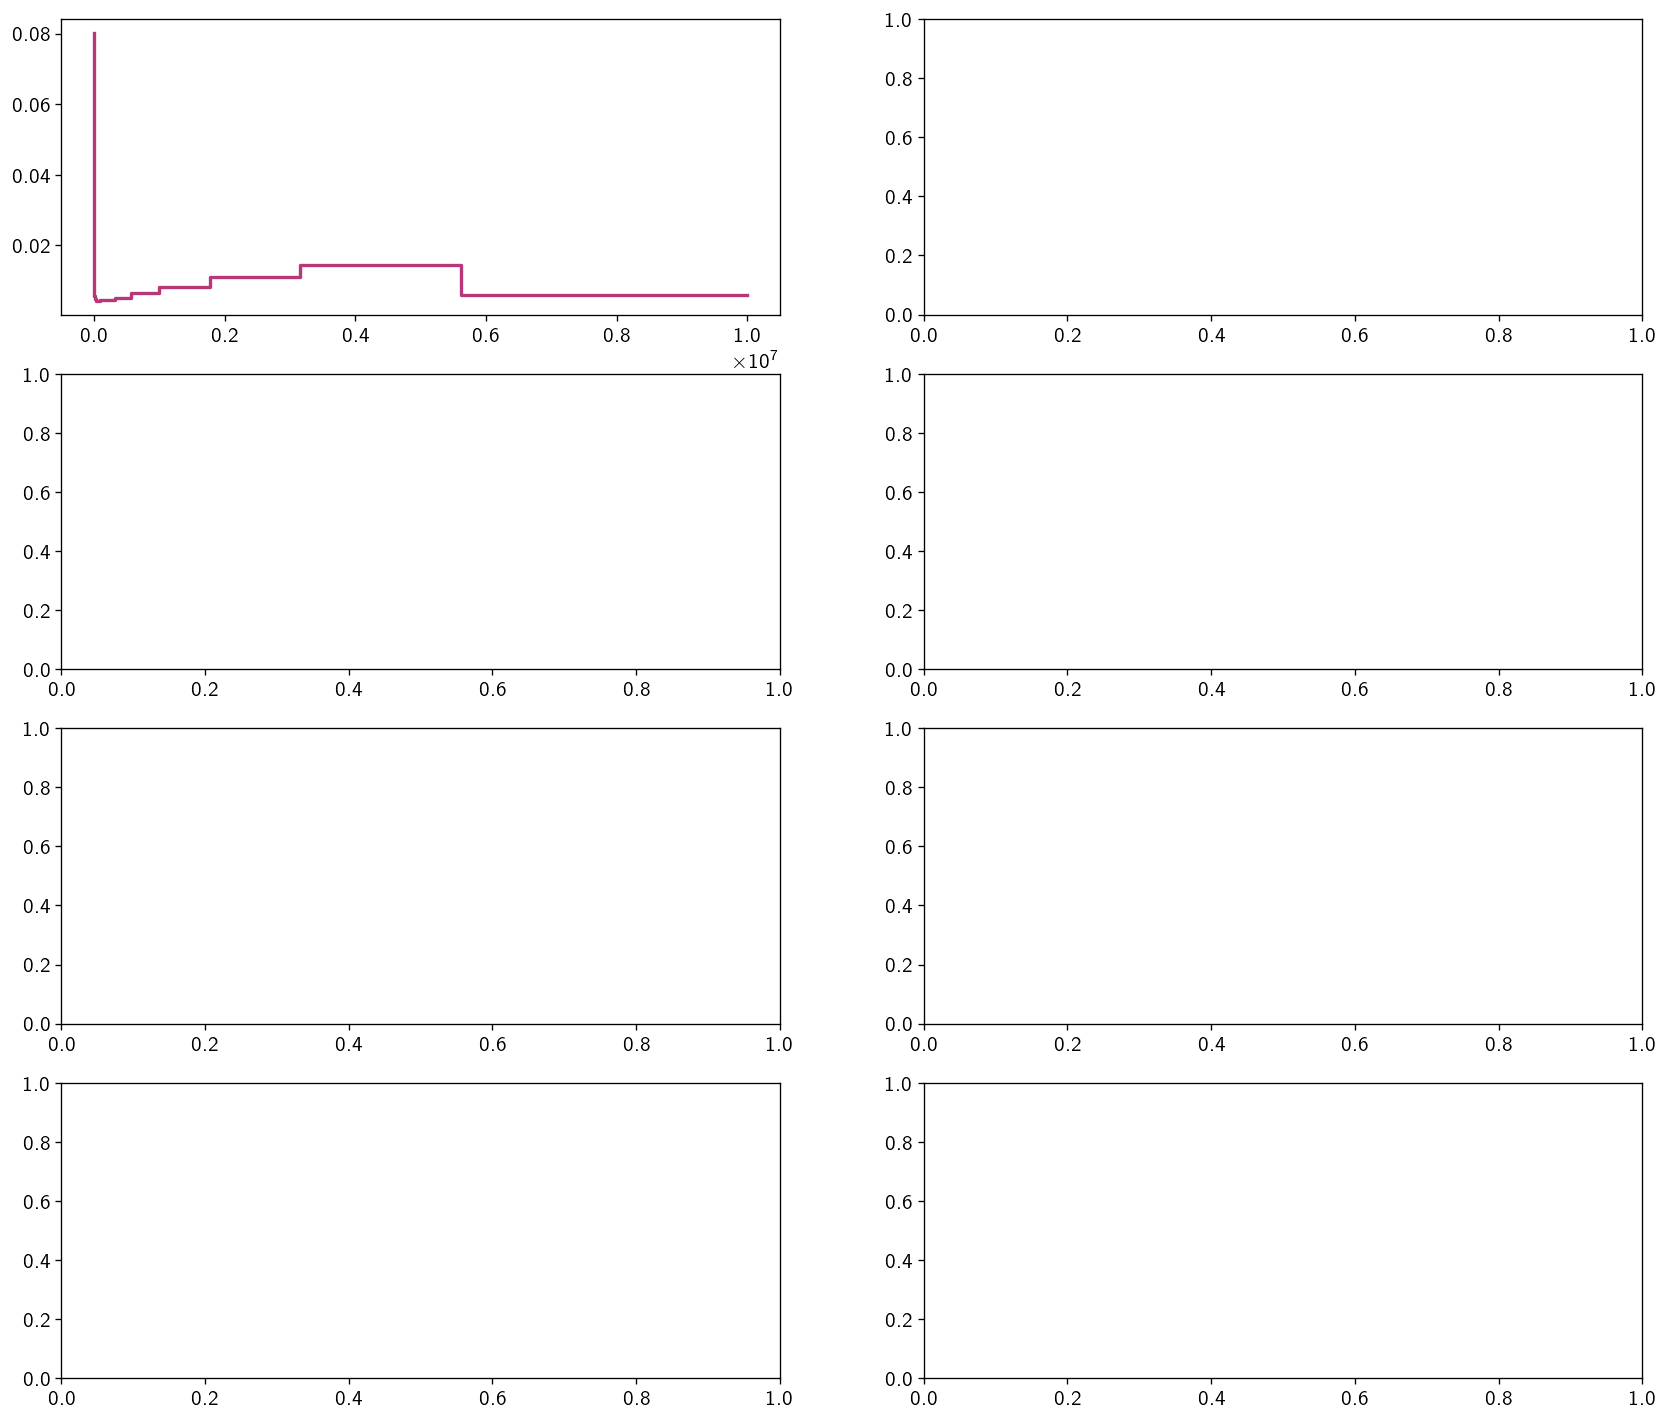

In [18]:
### Plotting Differential Sensitivities in one panel for the central 90% energy range ###

fig, axs = plt.subplots(4, 2, figsize=(17,15))

Ebins = 10**np.r_[3:7.1:.25]
gamma = [3.0]
dt = np.logspace(-2, 5, 8)

pow = np.log10(dt)
title = 'Differential Sensitivities' #: $\gamma={gamma:.1f}$ ' #, dt=10^{{{pow:.0f}}}$ s'

color_divisor = 4.0
sens_2 = {}
flux_2 = {}
diffsens_2 = {}



for (ax, i) in zip(axs.ravel(), dt):
    
    pow = np.log10(i)
    for g in gamma:
        if g == 2.0:
            sens_2[i] = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
            flux_2[i] = [s['E2dNdE']/1e3 for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
            diffsens_2[i] = hl.Hist(Ebins, flux_2[i])
            hl.plot1d(ax, diffsens_2[i], label = fr'MESC 7yr $\gamma={g:.1f}$ ', color = plt.get_cmap('magma')(g/color_divisor))
            
        elif g == 3.0:
            sens_3[i] = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
            flux_3[i] = [s['E2dNdE']/1e3 for s in sens_3[i]] #Units of Gev, divide by 1e3 for units of TeV
            diffsens_3[i] = hl.Hist(Ebins, flux_3[i])
            hl.plot1d(ax, diffsens_3[i], label = fr'MESC 7yr $\gamma={g:.1f}$ ', color = plt.get_cmap('magma')(g/color_divisor))
    
    ax.set(ylim = (1e-3, 1e0),
    xlabel=r'$E$ [GeV]',
    ylabel=r'$E^2\cdot dN/dE~~[\text{TeV}\,\text{cm}^2\,\text{}]$',
    title=fr'$dt=10^{{{pow:.0f}}}$ s'
    )
    #ax.set_ylim(top = 1e3)
    ax.grid()
    ax.loglog()
    ax.legend(bbox_to_anchor=(1.05, 1), prop={'size': 10})
    
fig.suptitle(title, y = .92, fontsize=20) #, fontdict = {'fontsize' : 100})
plt.subplots_adjust(wspace = .4, hspace=.35)
fig.savefig('/home/mkovacevich/public_html/plots/DiffSens/Differential_Sensitivity.png',bbox_inches='tight')

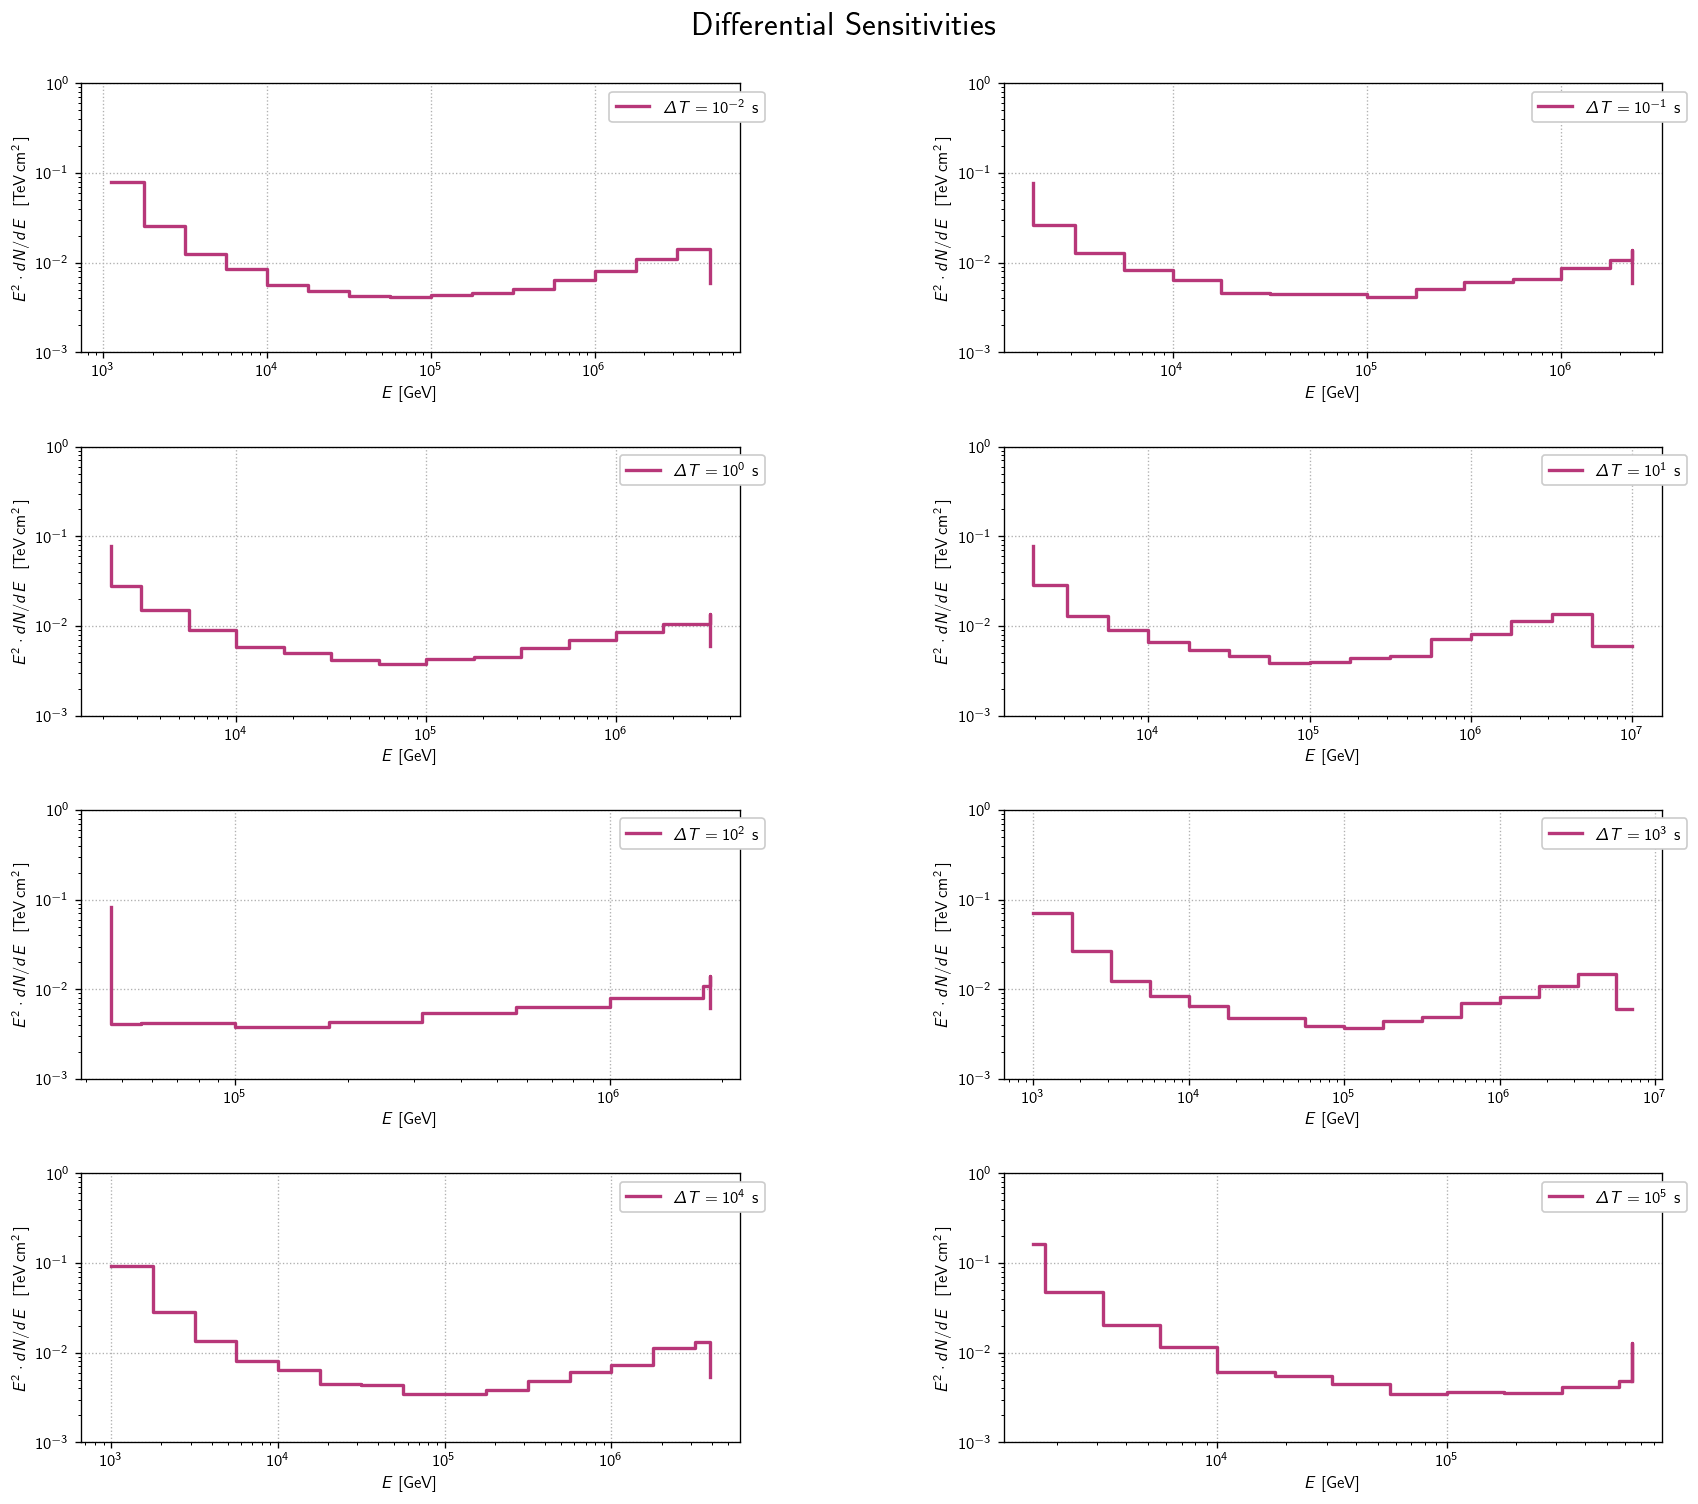

In [15]:
### Testing out using less bins at higher energies ###

fig, axs = plt.subplots(4, 2, figsize=(17,15))

E05 = [1115.37, 1925.03, 2202.24, 1946.61, 46753.5, 622.752, 605.385, 1580.19]
E95 = [5.06988*10**6, 2.31991*10**6, 3.12847*10**6, 1.12488*10**8, 1.8533*10**6, 7.12554*10**6, 3.91361*10**6, 642764.]
gamma = [2.0]
dt = np.logspace(-2, 5, 8)

pow = np.log10(dt)
title = 'Differential Sensitivities' #: $\gamma={gamma:.1f}$ ' #, dt=10^{{{pow:.0f}}}$ s'

color_divisor = 4.0
sens_2 = {}
flux_2 = {}
diffsens_2 = {}

for (ax, i, Emin, Emax) in zip(axs.ravel(), dt, E05, E95):
    g = 2.0
    pow = np.log10(i)
    Ebins = 10**np.r_[3:7.01:.25]
    Ebins = np.clip(Ebins, Emin, Emax)

    sens_2[i] = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
    flux_2[i] = [s['E2dNdE']/1e3 for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
    #len(flux_2[i:15])
    diffsens_2[i] = hl.Hist(Ebins, flux_2[i])
    hl.plot1d(ax, diffsens_2[i], label = fr'$\Delta T=10^{{{pow:.0f}}}$ s', color = plt.get_cmap('magma')(g/color_divisor))
            
            
    ax.set(ylim = (1e-3, 1e0),
    xlabel=r'$E$ [GeV]',
    ylabel=r'$E^2\cdot dN/dE~~[\text{TeV}\,\text{cm}^2\,\text{}]$'
    )
    #ax.set_ylim(top = 1e3)
    ax.grid()
    ax.loglog()
    ax.legend(bbox_to_anchor=(1.05, 1), prop={'size': 10})
    
fig.suptitle(title, y = .92, fontsize=20) #, fontdict = {'fontsize' : 100})
plt.subplots_adjust(wspace = .4, hspace=.35)
fig.savefig('/home/mkovacevich/public_html/Qual/Central90_DifferentialSensitivity.png',bbox_inches='tight')

[2.4233663571653032,
 2.2802476938832275,
 2.1080123562426776,
 2.203584580510963,
 2.0811522324981047,
 2.243067581911558,
 2.2229772447395866,
 2.37652006884471,
 2.4838415567723287,
 2.3087106571291898,
 2.1825213160897414,
 2.2764660348690673,
 2.201376946787097,
 2.2849636983369783,
 2.351486898717301,
 2.1678295828459446]